# CV part one

В этой тетрадке мы рассмотрим задачу распознавания лиц на примере датасета [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

**Предполагаем, что ноутбук запущен внутри Yandex DataSphere**

In [1202]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision.models import resnet34
from data_utils import CelebADataset, SimpleDataset, SimpleTripletSampler
from model.model import SomeModel
from trainer.trainer import Trainer
from utils import (top_n_accuracy, 
                   top_n_preds, 
                   compute_accs, 
                   get_embeds, 
                   l2_dist, 
                   set_seed
                  )

import matplotlib.pyplot as plt
from warnings import filterwarnings

filterwarnings("ignore")
%matplotlib inline

## Data

Качаем архив с данными с Yandex Object Storage и распаковываем в текущую папку.

Структура архива:
- /celeba_data/
    - train.csv
    - val.csv
    - images/{image}.jpg

CSV файлы содержат название файла (`image`) и его лейбл (`label`).

In [1137]:
from cloud_ml.storage.api import Storage
# insert access and secret keys
s3 = Storage.s3(access_key="...", secret_key="...")
# downloading contents of the remote file into the local one
s3.get('dl-hse-2021/celeba_data.zip', './celeba_data.zip')

In [1138]:
#!:bash
unzip -q ./celeba_data.zip -d ./ && rm celeba_data.zip

## Задание 1
**(0.2 балла)** Напишите класс датасет, который будет возвращать картинку и ее лейбл.

In [1142]:
celeb_dataset = CelebADataset(train=True, path="./celeba_data/")

test_sample = celeb_dataset[0]

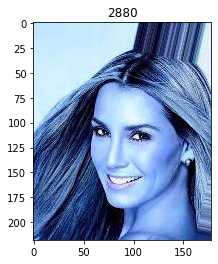

In [1171]:
plt.title(test_sample["label"])
plt.imshow(np.transpose(test_sample["sample"], (1, 2, 0)))
plt.show()

## Задание 2
**(0.2 балла)** Напишите функцию, которая будет считать метрику top-n accuracy.

$$TopN \ Accuracy = \frac{Number \ of \ objects \ with \ correct \ answer \ among \ topN \ predictions}{Total \ number \ of \ objects}$$

*Example:*

![image](https://www.baeldung.com/wp-content/ql-cache/quicklatex.com-ae746981c7a437b7e1fc2831e5d76d57_l3.svg)  
$Top3 \ Accuracy = \frac{4}{5} = 0.8$

*Hint:* Для каждого объекта выбираем `n` наиболее уверенных предсказаний. Если среди них есть правильный ответ, то увеличиваем числитель и знаменатель на единицу, иначе увеличиваем только знаменатель.

In [1173]:
targets = np.array([1, 0, 2, 2])
preds = np.array([
    [1, 0, 3],
    [3, 4, 0],
    [0, 2, 3],
    [3, 4, 2]
])

assert top_n_accuracy(preds, targets, 2) == 2 / 4

## Задание 3
**(0.2 балла)** Решите задачу без дообучения.

*Step-by-step:*
1. Инициализируйте предобученную сетку (`backbone`).
1. Прогоните через нее все картинки из валидационного датасета и сложите полученные эмбеддинги в массив.
1. Для каждого вектора найдите ближайшие к нему векторы и отсортируйте их по расстоянию (cosine, euclidian, ...). Лейблы соседних векторов будут предсказаниями для текущего вектора.
1. Оставьте топ-5 уникальных предсказаний.
1. Посчитайте и выведите метрики:
    1. top-1 accuracy
    1. top-5 accuracy

*Вопросы:*
1. Зачем мы заменяем последний линейный слой на `Identity` ?
1. Зачем используем на сетке метод `eval` ?

*Hints:*
1. Для расчета попарных расстояний лучше не использовать циклы, а считать все в матрицах. Описание подхода к расчету L2 расстояний: [link](https://math.stackexchange.com/questions/3147549/compute-the-pairwise-euclidean-distance-matrix)
1. Так можно использовать sklearn реализации: [link](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.pairwise)
1. Для получения top-k предсказаний не обязательно сортировать весь массив.

*Ответы:*

1. Identity - пропускает выходы последнего слоя as is. В этой задаче не нужна голова-классификатор, достаточно будет скоров/эмбедингов бэкбона
1. Некоторые блоки сети по разному ведут себя на трейне и инференсе, методом `eval()` мы переключаем их на режим инференса

In [1183]:
#!L

DEVICE = torch.cuda.current_device() if torch.cuda.is_available() else "cpu"

backbone = resnet34(pretrained=True)
backbone.fc = nn.Identity()
backbone = backbone.eval()
backbone.to(DEVICE)

celeb_val = DataLoader(CelebADataset(train=False, path="./celeba_data/"), shuffle=False, pin_memory=True)

In [1184]:
#!L

embeds, labels = get_embeds(backbone, celeb_val)
dists = l2_dist(embeds)

np.save("val_embeds.npy", embeds)
np.save("val_labels.npy", labels)
np.save("val_dists.npy", dists)

100%|██████████| 19867/19867 [04:50<00:00, 68.46it/s]


In [1186]:
#!M
# embeds = np.load("val_embeds.npy")
# dists  = np.load("val_dists.npy")
    
baseline_top_1_acc, baseline_top_5_acc = compute_accs(labels, dists)

print(f"TOP 1 ACCURACY: %.3f" % baseline_top_1_acc)
print(f"TOP 5 ACCURACY: %.3f" % baseline_top_5_acc)

TOP 1 ACCURACY: 0.160
TOP 5 ACCURACY: 0.273


## Задание 4
**(0.4 балла)** Решите задачу с дообучением на эмбеддингах.

*Step-by-step:*
1. Напишите небольшую сетку произвольной архитектуры, которая будет использовать эмбеды, выдаваемые `backbone` сетью.
1. Напишите класс Dataset, который будет возвращать эмбединг и лейбл.
1. Напишите класс Sampler [PyTroch docs](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler), который будет отвечать за правильность сбора тренировочных батчей: якорный пример, позитивный, негативный.
1. Обучите ее на тренировочном датасете:
    1. Лосс -- [triplet loss](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html).
    1. Метрика -- top-5 accuracy.
1. Посчитайте top-1 и top-5 accuracy на валидации. Насколько сильно они отличаются от того, что получилось в предыдущем задании?


*Hints:*
1. Убедитесь, что у каждого лейбла есть как минимум 2 примера, иначе не получится достать позитивный пример.
1. Лучше предварительно прогнать все картинки из трейна и сохранить полученные эмбеддинги, чтобы при обучении сети грузить только эмбеды (векторы).

In [1187]:
#!L
# сразу доформируем эмбеды

celeb_train = DataLoader(CelebADataset(train=True), shuffle=False, pin_memory=True)

train_embeds, train_labels = get_embeds(backbone, celeb_train)

np.save("train_embeds.npy", train_embeds)
np.save("train_labels.npy", train_labels)

100%|██████████| 162770/162770 [39:58<00:00, 67.86it/s]


In [1190]:
#!L

# triplet sampler sanity check
def sanity():
    train_embdes = torch.tensor(np.load("train_embeds.npy"), device=DEVICE)
    train_labels = torch.tensor(np.load("train_labels.npy"), device=DEVICE)
    dataset = SimpleDataset(train_embeds, train_labels)
    sampler = SimpleTripletSampler(dataset)
    loader  = DataLoader(dataset=dataset, sampler=sampler, batch_size=10)
    
    batch = next(iter(loader))
    
    assert (batch["labels"][0] == batch["labels"][1]).all(), 'Positive labels dont match'
    assert (batch["labels"][0] != batch["labels"][2]).all(), 'Negative labels dont mismatch'
    print("Success!")
    
sanity()

Success!


/home/jupyter/work/resources/simple_examples_for_cv/simple_torch_example/data_utils.py:94: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  pos_idxs = torch.nonzero(self.dataset.labels == anchor_label)


In [1205]:
#!L

train_set = SimpleDataset(
                    torch.tensor(np.load("train_embeds.npy"), device=DEVICE, requires_grad=True), 
                    torch.tensor(np.load("train_labels.npy"), device=DEVICE, requires_grad=False)
            )
val_set   = SimpleDataset(
                    torch.tensor(np.load("val_embeds.npy"), device=DEVICE, requires_grad=True), 
                    torch.tensor(np.load("val_labels.npy"), device=DEVICE, requires_grad=False)
            )

model = SomeModel()
opt = optim.Adam(model.parameters(), lr=1e-4)
trainer = Trainer(model, opt, train_set, val_set, batch_size=1024, n_hardest=700)

trainer.train(20)

model.eval()
# load best checkpoint
model.load("./best_checkpoint.pth")

new_embeds, new_labels = get_embeds(model, val_set)
new_dists = l2_dist(new_embeds)
top_1_acc, top_5_acc = compute_accs(new_labels, new_dists)

print(f"TOP 1 ACCURACY: %.3f" % top_1_acc)
print(f"TOP 5 ACCURACY: %.3f" % top_5_acc)

Batch mean train Loss:  0.6209	Batch mean val Loss:  0.3637
Batch mean train Loss:  0.5264	Batch mean val Loss:  0.3350
Batch mean train Loss:  0.4980	Batch mean val Loss:  0.3308
Batch mean train Loss:  0.4819	Batch mean val Loss:  0.3238
Batch mean train Loss:  0.4710	Batch mean val Loss:  0.3174
Batch mean train Loss:  0.4659	Batch mean val Loss:  0.3008
Batch mean train Loss:  0.4522	Batch mean val Loss:  0.3090
Batch mean train Loss:  0.4486	Batch mean val Loss:  0.3128
Batch mean train Loss:  0.4409	Batch mean val Loss:  0.2960
Batch mean train Loss:  0.4357	Batch mean val Loss:  0.2946
Batch mean train Loss:  0.4250	Batch mean val Loss:  0.2948
Batch mean train Loss:  0.4253	Batch mean val Loss:  0.3019
Batch mean train Loss:  0.4222	Batch mean val Loss:  0.2952
Batch mean train Loss:  0.4161	Batch mean val Loss:  0.3022
Batch mean train Loss:  0.4094	Batch mean val Loss:  0.2903


  0%|          | 0/159 [00:00<?, ?it/s]/home/jupyter/work/resources/simple_examples_for_cv/simple_torch_example/data_utils.py:94: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  pos_idxs = torch.nonzero(self.dataset.labels == anchor_label)
  0%|          | 0/159 [00:00<?, ?it/s]

Batch mean train Loss:  0.4002	Batch mean val Loss:  0.2789


  0%|          | 0/159 [00:00<?, ?it/s]

Batch mean train Loss:  0.3981	Batch mean val Loss:  0.2838


  0%|          | 0/159 [00:00<?, ?it/s]

Batch mean train Loss:  0.4009	Batch mean val Loss:  0.2850


  0%|          | 0/159 [00:00<?, ?it/s]

Batch mean train Loss:  0.3948	Batch mean val Loss:  0.2840


 54%|█████▍    | 86/159 [17:20<14:47, 12.15s/it]

Batch mean train Loss:  0.3958	Batch mean val Loss:  0.2927


ModuleAttributeError: 'SomeModel' object has no attribute 'load'

100%|██████████| 20/20 [01:03<00:00,  3.15s/it]
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:815: UserWarning: The following variables cannot be serialized: trainer
  warnings.warn(message)


In [1230]:
#!L

# new_set = DataLoader(CelebADataset(train=False), shuffle=False, pin_memory=True)

model.eval()
# load best checkpoint
model.load_state_dict(torch.load("./best_checkpoint.pth"))


def final_eval():
    embeddings = []
    labels = []
    for batch in val_set:
        embedding = model.net(batch["sample"].to(DEVICE))
        embeddings.append(embedding.detach().cpu().numpy().reshape(1, 512))
        labels.append(batch["label"].cpu().numpy().reshape(1, -1))
        torch.cuda.empty_cache()
    
    embeddings, labels = np.concatenate(embeddings), np.concatenate(labels).squeeze()
    
    return embeddings, labels

new_embeds, new_labels = final_eval()
new_dists = l2_dist(new_embeds)
top_1_acc, top_5_acc = compute_accs(new_labels, new_dists)

print(f"TOP 1 ACCURACY: %.3f" % top_1_acc)
print(f"TOP 5 ACCURACY: %.3f" % top_5_acc)

TOP 1 ACCURACY: 0.158
TOP 5 ACCURACY: 0.312
